# Breast Cancer Images
Loads images and runs it through a CapsNet.

In [18]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import skimage.transform
import copy

In [2]:
df = pd.read_csv("descriptions.csv")

In [3]:
#Helper function to compare images. Smaller images are the wanted cropped images.
def mult(dims):
    return dims[0] * dims[1]    

In [12]:
#Create labels. 1 means malignat and 0 means for benign
pathology = list(df['pathology'])
for i in range(len(pathology)):
    if pathology[i][0] == 'M':
        pathology[i] = 1
    else :
        pathology[i] = 0

In [5]:
data = []
labels = []
indices = []
labels = []

In [6]:
#Iterate over the folder structure of the images 
#and extract the pictures. Choose the cropped image, not the ROI image

first_level_list = sorted(os.listdir('CBIS-DDSM'))

for i in range(len(os.listdir('CBIS-DDSM'))-1): 
    first_level = first_level_list[i+1]
    try:
        second_level_list = os.listdir('CBIS-DDSM/{}'.format(first_level))
        
        #Should there be two folders, go inside and chose the folder which contains the cropped image
        #If there is only one folder, chose this one
        if len(second_level_list) == 2:
            if 'cropped' in str(os.listdir('CBIS-DDSM/{}/{}'.format(first_level,second_level_list[0]))):
                second_level = second_level_list[0]
            elif 'cropped' in str(os.listdir('CBIS-DDSM/{}/{}'.format(first_level,second_level_list[1]))):
                second_level = second_level_list[1]
        else:
            second_level = os.listdir('CBIS-DDSM/{}'.format(first_level))[0] 
        
        third_level = os.listdir('CBIS-DDSM/{}/{}'.format(first_level,second_level))[0]
        fourth_level = os.listdir('CBIS-DDSM/{}/{}/{}'.format(first_level,second_level,third_level))

        #These lines just make sure that we really get the cropped images. 
        #They are chosen by size, since they are much smaller
        ds_0 = pydicom.dcmread('CBIS-DDSM/{}/{}/{}/{}'.format(first_level,second_level,third_level,fourth_level[0]))
        if mult(ds_0.pixel_array.shape) < 1500 * 1500:
        #try:
            training_data.append(ds_0.pixel_array)
            indices.append(i)
       #except: AttributeError,print(i)
        else:
        #try:
            ds_1 = pydicom.dcmread('CBIS-DDSM/{}/{}/{}/{}'.format(first_level,second_level,third_level,fourth_level[1]))
            if mult(ds_1.pixel_array.shape) < 2000*2000:               
                training_data.append(ds_1.pixel_array)
                indices.append(i)


        #except: ValueError, print(i)

    except: NotADirectoryError

In [8]:
#Place the indices of the labels corresponding to the images
for i in range(len(indices)):
    labels.append(pathology[i])

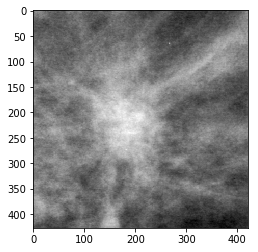

1


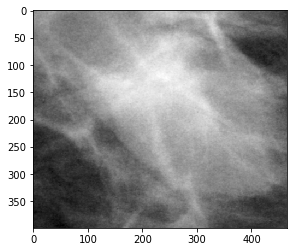

1


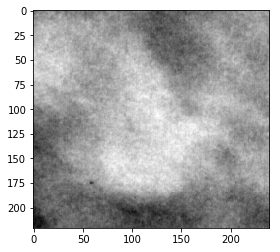

0


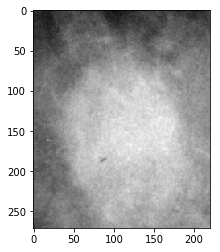

0


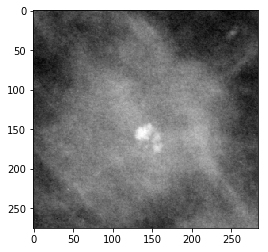

0


In [10]:
#Plot some cropped training images
for i in range(5):
    plt.imshow(training_data[i], cmap='gray')
    plt.show()
    print(labels[i])

### Resize images to (100,100) so that they are all the same size, and also to quicken learning time

In [29]:
training_data_copy = copy.copy(training_data)
#Downsample the cropped images, to fasten learning
for i in range(len(training_data_copy)):
    training_data_copy[i] = skimage.transform.resize(training_data_copy[i], output_shape=(100,100),order=5,preserve_range=True)

/anaconda3/envs/ann/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [30]:
def get_training_batch(batch_size):
    """Generator to provide training batches."""
    # Create random indices for shuffling the data.
    random_indices = np.random.choice(
                                a=1000,
                                size=1000,
                                replace = False
                                )
    # Shuffle the images and the labels.
    training_images = training_data_copy[random_indices]
    training_labels = labels[random_indices]
    # For the number of batches.
    for i in range(len(training_data_copy) // batch_size):
        # Compute the start and the end point of the batch.
        on = i * batch_size
        off = on + batch_size
        # Create batch.
        batch = training_data_copy[on:off], labels[on:off]
        yield batch

In [32]:
import tensorflow as tf
import numpy as np
from layers.capslayer import CapsLayer
from layers.convcapslayer import ConvCapsLayer
from layers.convlayer import ConvLayer
from layers.denselayer import DenseLayer


# Training Parameters
EPOCHS = 30
TRAINING_BATCH_SIZE = 128

def main():
    """ Training CapsNet.

    The data flow graph is designed and the training session is run.
    """

    # Define the placeholders.
    image_placeholder = tf.placeholder(dtype=tf.float32, shape=[None, 100, 100])
    label_placeholder = tf.placeholder(dtype=tf.int64, shape=[None])
    # Read out the batch size from the placeholders.
    batch_size = tf.shape(image_placeholder)[0]

    # Convolutional layer.
    with tf.variable_scope('ReLU_Conv1'):
        # Add fourth dimension (number of channels) to the images, because it is
        # needed for convolution.
        image_reshaped = tf.expand_dims(image_placeholder, axis=-1)
        convolution = ConvLayer(
                        kernel_size = 9,
                        stride = 1,
                        padding = 'VALID',
                        channels = 256,
                        activation_function = 'ReLU'
                      )(image_reshaped)

    # Primary Caps layer. Does another convolution and cuts it into capsules.
    with tf.variable_scope('Primary_Caps'):
        primary_caps = ConvCapsLayer(
                            kernel_size = 9,
                            stride = 2,
                            padding = 'VALID',
                            dimension = 8,
                            channels = 32,
                        )(convolution)

    # Digit Caps layer. Basically the readout layer, that decides if the network
    # recognized a certain digit or not.
    with tf.variable_scope('Digit_Caps'):
        digit_caps = CapsLayer(
                            count2 = 2, # changed from 10
                            dim2 = 16,
                            rout_iter = 3
                     )(primary_caps)

    # Calculate the loss and the accuracy of the read out.
    with tf.variable_scope('Loss'):
        loss, accuracy = calculate_loss_accuracy(digit_caps, label_placeholder)

    # Reconstructor that reconstructs the image from the representation of the
    # digit capsules. Consist of three dense layers.
    with tf.variable_scope('Dense1'):
        # Mask out (set to zero) all but the correct digit capsule and flatten
        # the tensor for the dense layer.
        digit_caps_flat = mask_and_flatten_digit_caps(digit_caps, label_placeholder)
        dense_1 = DenseLayer(
                        n_out = 512,
                        activation_function = 'ReLU'
                  )(digit_caps_flat)

    with tf.variable_scope('Dense2'):
        dense_2 = DenseLayer(
                        n_out = 1024,
                        activation_function = 'ReLU'
                  )(dense_1)

    with tf.variable_scope('Dense3'):
        dense_3 = DenseLayer(
                        n_out = 100*100,
                        activation_function = 'Sigmoid'
                  )(dense_2)
        # Reshape the output of this layer to same shape as the original image,
        # to obtain the reconstruction.
        reconstructions = tf.reshape(dense_3, shape=[batch_size, 100, 100])

    # Calculate the loss of the reconstruction.
    with tf.variable_scope('Reconstruction_Loss'):
        reconstruction_loss = calculate_reconstruction_loss(reconstructions, image_placeholder)

    # Set AdamOptimizer with default values (as described in the paper) as
    # optimizer. It minimizes the sum of the loss and the reconstruction loss.
    with tf.variable_scope('Optimizer'):
        optimizer = tf.train.AdamOptimizer()
        total_loss = loss + reconstruction_loss
        training_step = optimizer.minimize(total_loss)

    # Define which nodes to save, to display later in tensorboard.
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('accuracy', accuracy)
    tf.summary.scalar('reconstruction_loss', reconstruction_loss)
    tf.summary.scalar('total_loss', total_loss)
    merged_summaries = tf.summary.merge_all()

    # Define the tensorflow "writer" for tensorboard and the tensorflow "saver"
    #to save the learned weights.
    train_writer = tf.summary.FileWriter("./summaries/train", tf.get_default_graph())
    validation_writer = tf.summary.FileWriter("./summaries/validation", tf.get_default_graph())
    saver = tf.train.Saver()

    # Session to train the model.
    with tf.Session() as sess:
        # Count steps for displaying in tensorboard.
        step = 30*np.ceil(60000.0/128.0)
        # Restore the weights.
        saver.restore(sess, "./tmp/model.ckpt")
        # Initialize best loss to infinity to be able to compare the current
        # validation loss to the best validation loss so far and store the
        # weights only if the mode was better.
        best_validation_loss = 0.015

        # Train the network for the specified number of epochs.
        for epoch in range(EPOCHS):
            # Print current epoch number for verifying that the network trains.
            print("Epoch {}...".format(epoch))

            # Get the validation batch.
            image_samples, label_samples = mnist_data.get_validation_batch()
            # Validate the current performance.
            _summaries, _loss = sess.run(
                                [merged_summaries, total_loss],
                                feed_dict = {image_placeholder: image_samples,
                                             label_placeholder: label_samples}
                                    )
            # Save the summaries.
            validation_writer.add_summary(_summaries, step)
            # Print current loss for eyeballing training process.
            print("Loss: {}".format(_loss))
            # Save weights, if the model had a lower validation loss than
            # in the previous epochs.
            if _loss < best_validation_loss:
                save_path = saver.save(sess, "./tmp/model.ckpt")
                # Update the best loss so far.
                best_validation_loss = _loss

            # Initialize a generator for training batches of specified size.
            training_generator = mnist_data.get_training_batch(TRAINING_BATCH_SIZE)
            # For all batches train the network.
            for image_samples, label_samples in training_generator:
                _, _summaries  = sess.run(
                                    [training_step,merged_summaries],
                                    feed_dict = {image_placeholder: image_samples,
                                                 label_placeholder: label_samples}
                                  )
                # Save the summaries.
                train_writer.add_summary(_summaries, step)
                # Count step number one up.
                step += 1



def mask_and_flatten_digit_caps(digit_caps, labels):
    """Mask out and flat the digit caps.

    All but the 16 values of the capsule corresponding to the correct label
    are set to 0. Then the digit caps are reshaped from [batch_size, 10, 16] to
    [batch_size, 10*16].
    """
    # Create a tensor in the same shape as the digit caps with ones at the
    # entries that are corresponding to the entries for the correct label
    # and zero everywhere else.
    labels = tf.one_hot(labels, depth=2) # changed from 10
    labels = tf.expand_dims(labels, axis=-1)
    labels = tf.tile(labels, [1,1,16])
    # Mask out the digit caps.
    masked_digit_caps = digit_caps * labels
    # Read out the batch size from the labels.
    batch_size = tf.shape(labels)[0]
    # Flat the digit caps.
    masked_and_flat = tf.reshape(masked_digit_caps, shape=[batch_size,2*16]) # changed 10 to 2
    return masked_and_flat

def calculate_loss_accuracy(digit_caps, labels):
    """Calculate the loss and the accuracy.

    The loss implements the loss from the paper. For more information check our
    report.
    Accuracy is computed by taking the digit with "longest" capsule, meaning the
    digit where the model is the most sure, that it is in the image, as the
    prediction of the network.
    """
    # Compute the length (euclidean norm) of the digit capsules.
    length_digit_caps = tf.norm(digit_caps, axis = 2)
    labels_one_hot = tf.one_hot(labels, depth=2) # changed from 10
    # Compute the false negative part of the loss.
    plus_loss =  labels_one_hot * tf.nn.relu(0.9 - length_digit_caps)
    # Compute the fals positive part of the loss.
    minus_loss = 0.5 * (1 - labels_one_hot) * tf.nn.relu(length_digit_caps - 0.1)
    # Compute the loss from those two parts
    loss = tf.reduce_sum(plus_loss + minus_loss, axis=-1)
    loss = tf.reduce_mean(loss)
    # Compute accuracy by comparing indices of longest capusle to the labels.
    correct_prediction = tf.equal(tf.argmax(length_digit_caps, 1), labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return loss, accuracy

def calculate_reconstruction_loss(reconstructions, images):
    """Calculate the loss of the reconstruction."""
    # As the reconstructor has a sigmoid read out layer scale pixel intensties
    # of the images down to [0,1].
    images = images/255.0
    # Compute the sum squared error between reconstruction and original image.
    squared_error = tf.squared_difference(reconstructions, images)
    sum_squared_error = tf.reduce_sum(squared_error, axis=-1)
    # Scale down the reconstruction loss to let it not dominate the loss.
    reconstruction_loss = 0.0005 * (100*100) * tf.reduce_mean(sum_squared_error) # changed 784 to 100*100
    return reconstruction_loss

if __name__ == '__main__':
    main()


Instructions for updating:
keep_dims is deprecated, use keepdims instead
INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt


InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [10000] rhs shape= [784]
	 [[Node: save/Assign_18 = Assign[T=DT_FLOAT, _class=["loc:@Dense3/Variable_1"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Optimizer/Dense3/Variable_1/Adam_1, save/RestoreV2:18)]]

Caused by op 'save/Assign_18', defined at:
  File "/anaconda3/envs/ann/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/envs/ann/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-b32b8fb663e0>", line 221, in <module>
    main()
  File "<ipython-input-32-b32b8fb663e0>", line 110, in main
    saver = tf.train.Saver()
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1293, in __init__
    self.build()
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1302, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1339, in _build
    build_save=build_save, build_restore=build_restore)
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 796, in _build_internal
    restore_sequentially, reshape)
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 471, in _AddRestoreOps
    assign_ops.append(saveable.restore(saveable_tensors, shapes))
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 161, in restore
    self.op.get_shape().is_fully_defined())
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 280, in assign
    validate_shape=validate_shape)
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 58, in assign
    use_locking=use_locking, name=name)
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/anaconda3/envs/ann/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Assign requires shapes of both tensors to match. lhs shape= [10000] rhs shape= [784]
	 [[Node: save/Assign_18 = Assign[T=DT_FLOAT, _class=["loc:@Dense3/Variable_1"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Optimizer/Dense3/Variable_1/Adam_1, save/RestoreV2:18)]]
